<a href="https://colab.research.google.com/github/IreneChouu/Face-privacy-protection-and-reconstruction-based-on-MAE/blob/main/FacePrivacyProtection_MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare
Check environment. Install packages if in Colab.


In [ ]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import cv2  # OpenCV for face detection
# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
fatal: destination path 'mae' already exists and is not an empty directory.


### Define utils

In [ ]:
# define the utils
# Define ImageNet mean and std for normalization
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [ ]:
# Function to detect faces in an image using OpenCV's Haar Cascade classifier
def detect_faces(image):
    # Load pre-trained Haar Cascade classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    return faces

# Function to apply privacy mask specifically to detected faces
def apply_privacy_mask_to_faces(image, faces):
    masked_image = image.copy()
    mask_size_ratio = 0.35  # Mask size as a fraction of the face size (one-fifth)

    for (x, y, w, h) in faces:
        # Calculate mask dimensions based on the face size
        mask_h = int(h * mask_size_ratio)
        mask_w = int(w * mask_size_ratio)

        # Randomly select a position within the face region for the mask
        mask_x = np.random.randint(x, x + (w - mask_w))
        mask_y = np.random.randint(y, y + (h - mask_h))

        # Apply a privacy mask to the randomly selected face region
        masked_image[mask_y:mask_y + mask_h, mask_x:mask_x + mask_w] = np.random.rand(mask_h, mask_w, 3) * 255

    return masked_image


### Load an image

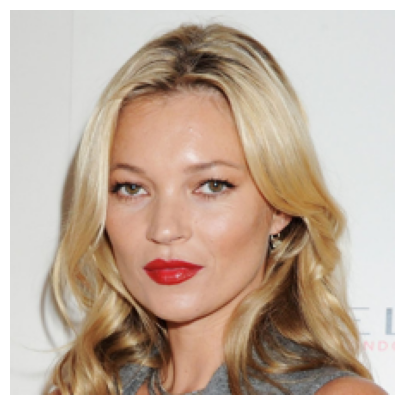

In [ ]:
# load an image
#img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
#img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img_url = 'https://hips.hearstapps.com/goodhousekeeping-uk/main/embedded/32567/kate-moss-main.jpg?resize=980:*'#一人
#img_url = 'https://images.squarespace-cdn.com/content/v1/5d1ae7b443a4be0001f321b6/fb7a5e86-d6ef-4476-984a-7199d61fad91/Jacinta+Anderson+PCP.jpg?format=100w'
#img_url = 'https://t4.ftcdn.net/jpg/02/77/68/51/240_F_277685185_UAYxm224UPelni1rxsuAUZQbfhly0RpL.jpg' #雙人
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [ ]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')



### Detect faces + Apply privacy protection mask specifically





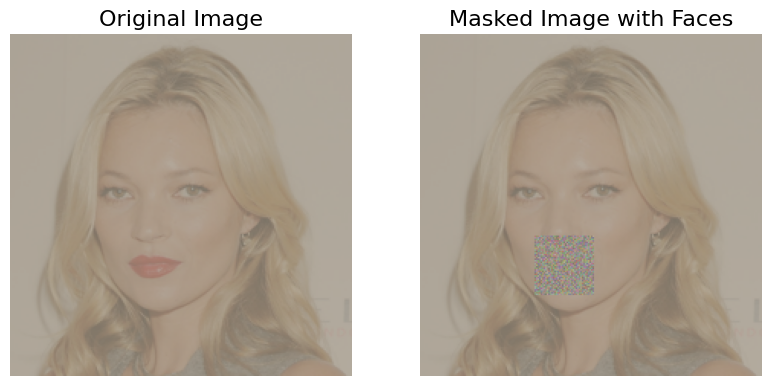

In [ ]:
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img).astype(np.uint8)  # Ensure the image is in uint8 format
# Detect faces in the input image
faces_coordinates = detect_faces(img)

# Apply privacy protection mask specifically to detected faces
masked_img_faces = apply_privacy_mask_to_faces(img, faces_coordinates)

# Display the original and masked images with faces privacy masked
plt.rcParams['figure.figsize'] = [15, 5]
plt.subplot(1, 3, 1)
show_image(torch.tensor(img / 255.), "Original Image")
plt.subplot(1, 3, 2)
show_image(torch.tensor(masked_img_faces / 255.), "Masked Image with Faces")


### Run the MAE model for privacy protection and reconstruction on the masked faces

MAE for Privacy Protection (Masked Faces):


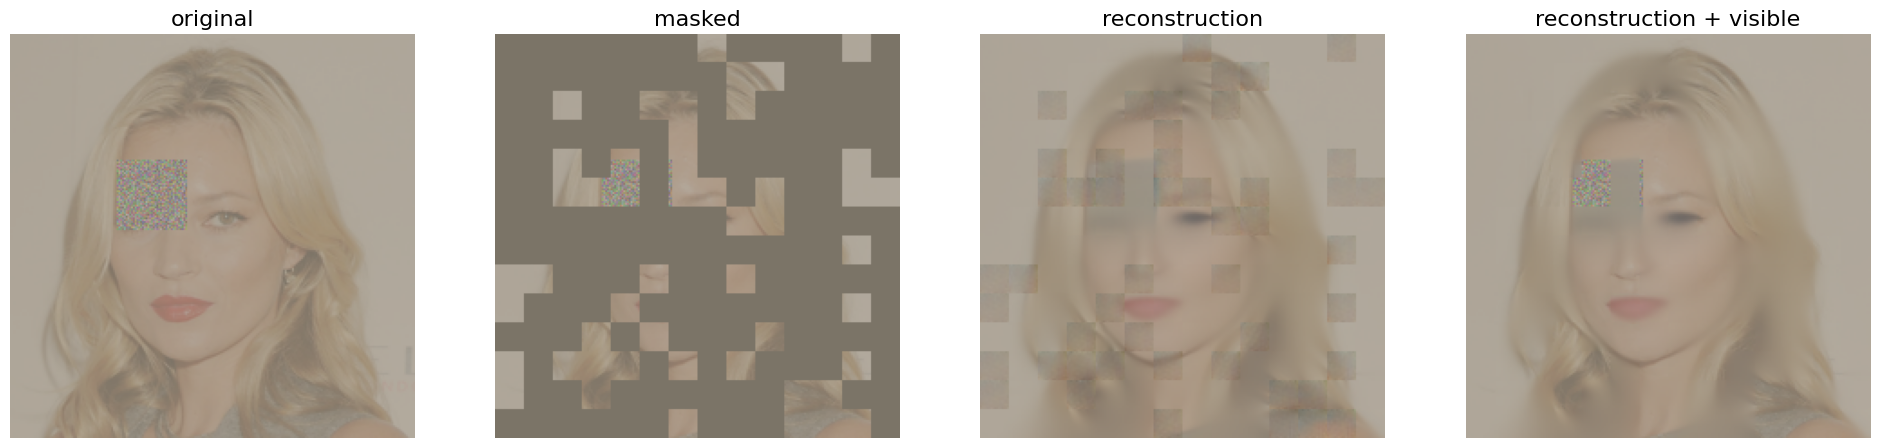

In [ ]:
# Run the MAE model for privacy protection and reconstruction on the masked faces
print('MAE for Privacy Protection (Masked Faces):')
run_one_image(masked_img_faces / 255., model_mae)